In [ ]:
# https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database

# Load dataset

In [117]:
from datasets import load_dataset

dataset = load_dataset('imagefolder', data_dir='jpeg')

Generating train split: 19113 examples [00:00, 23413.95 examples/s]
Generating test split: 2052 examples [00:00, 22138.26 examples/s]


In [119]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 19113
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2052
    })
})

In [120]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [121]:
id2label

{'0': 'COVID', '1': 'Lung_Opacity', '2': 'Normal', '3': 'Viral_Pneumonia'}

# Preprocess data

In [122]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [123]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [124]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [125]:
images = dataset.with_transform(transforms)

In [126]:
images

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 19113
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2052
    })
})

In [127]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

# Evaluate

In [128]:
import evaluate

accuracy = evaluate.load("accuracy")

In [129]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [130]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [131]:
training_args = TrainingArguments(
    output_dir="covid_radiology_classification",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=images["train"],
    eval_dataset=images["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)



c:\Users\Jon\AppData\Local\Programs\Python\Python311\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [132]:
trainer.train()

  1%|          | 10/894 [09:50<14:28:31, 58.95s/it]

{'loss': 1.4244, 'grad_norm': 1.0963715314865112, 'learning_rate': 5.555555555555556e-06, 'epoch': 0.03}


  2%|▏         | 20/894 [19:31<13:56:57, 57.46s/it]

{'loss': 1.3551, 'grad_norm': 1.341468334197998, 'learning_rate': 1.1111111111111112e-05, 'epoch': 0.07}


  3%|▎         | 30/894 [28:55<13:29:37, 56.22s/it]

{'loss': 1.1864, 'grad_norm': 1.1158761978149414, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.1}


  4%|▍         | 40/894 [38:17<13:20:58, 56.27s/it]

{'loss': 1.0766, 'grad_norm': 1.6345049142837524, 'learning_rate': 2.2222222222222223e-05, 'epoch': 0.13}


  6%|▌         | 50/894 [47:40<13:10:59, 56.23s/it]

{'loss': 0.9716, 'grad_norm': 1.3742119073867798, 'learning_rate': 2.777777777777778e-05, 'epoch': 0.17}


  7%|▋         | 60/894 [57:03<13:01:39, 56.23s/it]

{'loss': 0.9021, 'grad_norm': 1.440259575843811, 'learning_rate': 3.3333333333333335e-05, 'epoch': 0.2}


  8%|▊         | 70/894 [1:06:25<12:52:26, 56.25s/it]

{'loss': 0.8372, 'grad_norm': 2.468701124191284, 'learning_rate': 3.888888888888889e-05, 'epoch': 0.23}


  9%|▉         | 80/894 [1:15:47<12:41:38, 56.14s/it]

{'loss': 0.71, 'grad_norm': 2.5566012859344482, 'learning_rate': 4.4444444444444447e-05, 'epoch': 0.27}


 10%|█         | 90/894 [1:25:09<12:32:55, 56.19s/it]

{'loss': 0.668, 'grad_norm': 2.406503438949585, 'learning_rate': 5e-05, 'epoch': 0.3}


 11%|█         | 100/894 [1:34:31<12:23:48, 56.21s/it]

{'loss': 0.654, 'grad_norm': 2.3734657764434814, 'learning_rate': 4.9378109452736324e-05, 'epoch': 0.33}


 12%|█▏        | 110/894 [1:43:53<12:13:37, 56.14s/it]

{'loss': 0.6487, 'grad_norm': 3.772745132446289, 'learning_rate': 4.875621890547264e-05, 'epoch': 0.37}


 13%|█▎        | 120/894 [1:53:16<12:05:20, 56.23s/it]

{'loss': 0.5802, 'grad_norm': 3.142003297805786, 'learning_rate': 4.813432835820896e-05, 'epoch': 0.4}


 15%|█▍        | 130/894 [2:02:40<11:58:46, 56.45s/it]

{'loss': 0.5472, 'grad_norm': 2.129945993423462, 'learning_rate': 4.7512437810945275e-05, 'epoch': 0.44}


 16%|█▌        | 140/894 [2:12:04<11:48:34, 56.39s/it]

{'loss': 0.5766, 'grad_norm': 1.6510127782821655, 'learning_rate': 4.68905472636816e-05, 'epoch': 0.47}


 17%|█▋        | 150/894 [2:21:27<11:38:27, 56.33s/it]

{'loss': 0.5442, 'grad_norm': 4.180242538452148, 'learning_rate': 4.626865671641791e-05, 'epoch': 0.5}


 18%|█▊        | 160/894 [2:30:49<11:26:47, 56.14s/it]

{'loss': 0.5467, 'grad_norm': 2.1721503734588623, 'learning_rate': 4.564676616915423e-05, 'epoch': 0.54}


 19%|█▉        | 170/894 [2:40:12<11:18:21, 56.22s/it]

{'loss': 0.5042, 'grad_norm': 1.965132474899292, 'learning_rate': 4.502487562189055e-05, 'epoch': 0.57}


 20%|██        | 180/894 [2:49:35<11:10:05, 56.31s/it]

{'loss': 0.4568, 'grad_norm': 1.3181467056274414, 'learning_rate': 4.440298507462687e-05, 'epoch': 0.6}


 21%|██▏       | 190/894 [2:58:57<10:59:21, 56.19s/it]

{'loss': 0.4895, 'grad_norm': 5.093945503234863, 'learning_rate': 4.3781094527363184e-05, 'epoch': 0.64}


 22%|██▏       | 200/894 [3:08:20<10:51:15, 56.31s/it]

{'loss': 0.4335, 'grad_norm': 2.862863302230835, 'learning_rate': 4.3159203980099506e-05, 'epoch': 0.67}


 23%|██▎       | 210/894 [3:17:42<10:40:56, 56.22s/it]

{'loss': 0.441, 'grad_norm': 5.547560214996338, 'learning_rate': 4.253731343283582e-05, 'epoch': 0.7}


 25%|██▍       | 220/894 [3:27:04<10:31:40, 56.23s/it]

{'loss': 0.4164, 'grad_norm': 3.385962963104248, 'learning_rate': 4.191542288557214e-05, 'epoch': 0.74}


 26%|██▌       | 230/894 [3:36:26<10:22:26, 56.24s/it]

{'loss': 0.4016, 'grad_norm': 2.929270029067993, 'learning_rate': 4.1293532338308464e-05, 'epoch': 0.77}


 27%|██▋       | 240/894 [3:45:48<10:12:41, 56.21s/it]

{'loss': 0.4458, 'grad_norm': 3.9839675426483154, 'learning_rate': 4.067164179104478e-05, 'epoch': 0.8}


 28%|██▊       | 250/894 [3:55:11<10:03:15, 56.20s/it]

{'loss': 0.3729, 'grad_norm': 2.51804780960083, 'learning_rate': 4.00497512437811e-05, 'epoch': 0.84}


 29%|██▉       | 260/894 [4:04:33<9:54:48, 56.29s/it] 

{'loss': 0.4424, 'grad_norm': 2.8476176261901855, 'learning_rate': 3.9427860696517415e-05, 'epoch': 0.87}


 30%|███       | 270/894 [4:13:55<9:43:46, 56.13s/it]

{'loss': 0.3845, 'grad_norm': 2.6679203510284424, 'learning_rate': 3.8805970149253736e-05, 'epoch': 0.9}


 31%|███▏      | 280/894 [4:23:17<9:35:25, 56.23s/it]

{'loss': 0.4148, 'grad_norm': 2.5668435096740723, 'learning_rate': 3.818407960199005e-05, 'epoch': 0.94}


 32%|███▏      | 290/894 [4:32:39<9:25:38, 56.19s/it]

{'loss': 0.4365, 'grad_norm': 3.5620131492614746, 'learning_rate': 3.756218905472637e-05, 'epoch': 0.97}


                                                     
 33%|███▎      | 298/894 [4:50:50<9:17:57, 56.17s/it]

{'eval_loss': 0.43457603454589844, 'eval_accuracy': 0.8533138401559455, 'eval_runtime': 605.0614, 'eval_samples_per_second': 3.391, 'eval_steps_per_second': 0.213, 'epoch': 1.0}


 34%|███▎      | 300/894 [4:52:04<30:09:33, 182.78s/it]

{'loss': 0.3861, 'grad_norm': 2.243104934692383, 'learning_rate': 3.694029850746269e-05, 'epoch': 1.0}


 35%|███▍      | 310/894 [5:01:32<9:45:29, 60.15s/it]  

{'loss': 0.3548, 'grad_norm': 5.1564764976501465, 'learning_rate': 3.631840796019901e-05, 'epoch': 1.04}


 36%|███▌      | 320/894 [5:10:50<8:53:19, 55.75s/it]

{'loss': 0.3472, 'grad_norm': 2.3578574657440186, 'learning_rate': 3.5696517412935324e-05, 'epoch': 1.07}


 37%|███▋      | 330/894 [5:20:07<8:42:17, 55.56s/it]

{'loss': 0.3581, 'grad_norm': 2.8553011417388916, 'learning_rate': 3.5074626865671645e-05, 'epoch': 1.1}


 38%|███▊      | 340/894 [5:29:26<8:35:13, 55.80s/it]

{'loss': 0.3453, 'grad_norm': 2.3125998973846436, 'learning_rate': 3.445273631840796e-05, 'epoch': 1.14}


 39%|███▉      | 350/894 [5:38:44<8:25:09, 55.72s/it]

{'loss': 0.3465, 'grad_norm': 2.2761709690093994, 'learning_rate': 3.383084577114428e-05, 'epoch': 1.17}


 40%|████      | 360/894 [5:48:02<8:15:30, 55.68s/it]

{'loss': 0.3517, 'grad_norm': 3.6397781372070312, 'learning_rate': 3.32089552238806e-05, 'epoch': 1.21}


 41%|████▏     | 370/894 [5:57:19<8:06:21, 55.69s/it]

{'loss': 0.3483, 'grad_norm': 3.041107654571533, 'learning_rate': 3.258706467661692e-05, 'epoch': 1.24}


 43%|████▎     | 380/894 [6:06:35<7:55:16, 55.48s/it]

{'loss': 0.3323, 'grad_norm': 2.1249518394470215, 'learning_rate': 3.196517412935324e-05, 'epoch': 1.27}


 44%|████▎     | 390/894 [6:15:48<7:43:35, 55.19s/it]

{'loss': 0.3491, 'grad_norm': 3.385810613632202, 'learning_rate': 3.1343283582089554e-05, 'epoch': 1.31}


 45%|████▍     | 400/894 [6:25:03<7:35:35, 55.34s/it]

{'loss': 0.3778, 'grad_norm': 4.574250221252441, 'learning_rate': 3.0721393034825876e-05, 'epoch': 1.34}


 46%|████▌     | 410/894 [6:34:16<7:26:33, 55.36s/it]

{'loss': 0.3482, 'grad_norm': 2.2676148414611816, 'learning_rate': 3.009950248756219e-05, 'epoch': 1.37}


 47%|████▋     | 420/894 [6:43:31<7:19:42, 55.66s/it]

{'loss': 0.3271, 'grad_norm': 3.1906704902648926, 'learning_rate': 2.9477611940298512e-05, 'epoch': 1.41}


 48%|████▊     | 430/894 [6:52:45<7:07:13, 55.25s/it]

{'loss': 0.3447, 'grad_norm': 1.6864159107208252, 'learning_rate': 2.885572139303483e-05, 'epoch': 1.44}


 49%|████▉     | 440/894 [7:01:58<6:58:08, 55.26s/it]

{'loss': 0.3956, 'grad_norm': 3.548603057861328, 'learning_rate': 2.823383084577115e-05, 'epoch': 1.47}


 50%|█████     | 450/894 [7:11:12<6:48:19, 55.18s/it]

{'loss': 0.3642, 'grad_norm': 2.8710200786590576, 'learning_rate': 2.7611940298507467e-05, 'epoch': 1.51}


 51%|█████▏    | 460/894 [7:20:25<6:38:55, 55.15s/it]

{'loss': 0.3658, 'grad_norm': 2.0524094104766846, 'learning_rate': 2.6990049751243785e-05, 'epoch': 1.54}


 53%|█████▎    | 470/894 [7:29:37<6:30:22, 55.24s/it]

{'loss': 0.3204, 'grad_norm': 2.4224934577941895, 'learning_rate': 2.6368159203980103e-05, 'epoch': 1.57}


 54%|█████▎    | 480/894 [7:38:51<6:21:11, 55.25s/it]

{'loss': 0.3303, 'grad_norm': 4.03118371963501, 'learning_rate': 2.574626865671642e-05, 'epoch': 1.61}


 55%|█████▍    | 490/894 [7:48:04<6:11:15, 55.14s/it]

{'loss': 0.3017, 'grad_norm': 2.330455780029297, 'learning_rate': 2.512437810945274e-05, 'epoch': 1.64}


 56%|█████▌    | 500/894 [7:57:17<6:02:41, 55.23s/it]

{'loss': 0.3543, 'grad_norm': 3.559166669845581, 'learning_rate': 2.4502487562189054e-05, 'epoch': 1.67}


 57%|█████▋    | 510/894 [8:06:28<5:53:05, 55.17s/it]

{'loss': 0.3353, 'grad_norm': 3.401772975921631, 'learning_rate': 2.3880597014925373e-05, 'epoch': 1.71}


 58%|█████▊    | 520/894 [8:15:39<5:42:53, 55.01s/it]

{'loss': 0.3001, 'grad_norm': 1.9603865146636963, 'learning_rate': 2.325870646766169e-05, 'epoch': 1.74}


 59%|█████▉    | 530/894 [8:24:50<5:33:58, 55.05s/it]

{'loss': 0.2949, 'grad_norm': 2.404919385910034, 'learning_rate': 2.2636815920398012e-05, 'epoch': 1.77}


 60%|██████    | 540/894 [8:34:01<5:24:45, 55.04s/it]

{'loss': 0.2616, 'grad_norm': 2.131787061691284, 'learning_rate': 2.201492537313433e-05, 'epoch': 1.81}


 62%|██████▏   | 550/894 [8:43:13<5:17:08, 55.32s/it]

{'loss': 0.294, 'grad_norm': 6.047181129455566, 'learning_rate': 2.139303482587065e-05, 'epoch': 1.84}


 63%|██████▎   | 560/894 [8:52:24<5:06:55, 55.14s/it]

{'loss': 0.2698, 'grad_norm': 3.6763861179351807, 'learning_rate': 2.0771144278606967e-05, 'epoch': 1.87}


 64%|██████▍   | 570/894 [9:01:34<4:56:42, 54.95s/it]

{'loss': 0.3189, 'grad_norm': 2.603451728820801, 'learning_rate': 2.0149253731343285e-05, 'epoch': 1.91}


 65%|██████▍   | 580/894 [9:10:44<4:47:30, 54.94s/it]

{'loss': 0.3196, 'grad_norm': 1.9058599472045898, 'learning_rate': 1.9527363184079603e-05, 'epoch': 1.94}


 66%|██████▌   | 590/894 [9:19:57<4:41:09, 55.49s/it]

{'loss': 0.2477, 'grad_norm': 3.189695119857788, 'learning_rate': 1.890547263681592e-05, 'epoch': 1.97}


                                                     
 67%|██████▋   | 597/894 [9:37:07<4:41:05, 56.79s/it]

{'eval_loss': 0.34171006083488464, 'eval_accuracy': 0.8869395711500975, 'eval_runtime': 607.2879, 'eval_samples_per_second': 3.379, 'eval_steps_per_second': 0.212, 'epoch': 2.0}


 67%|██████▋   | 600/894 [9:39:35<11:57:09, 146.36s/it]

{'loss': 0.293, 'grad_norm': 5.287377834320068, 'learning_rate': 1.828358208955224e-05, 'epoch': 2.01}


 68%|██████▊   | 610/894 [9:49:05<4:40:10, 59.19s/it]  

{'loss': 0.3191, 'grad_norm': 4.733219623565674, 'learning_rate': 1.7661691542288558e-05, 'epoch': 2.04}


 69%|██████▉   | 620/894 [9:58:25<4:15:31, 55.96s/it]

{'loss': 0.2756, 'grad_norm': 3.7800238132476807, 'learning_rate': 1.7039800995024876e-05, 'epoch': 2.08}


 70%|███████   | 630/894 [10:07:43<4:04:49, 55.64s/it]

{'loss': 0.3027, 'grad_norm': 2.270043134689331, 'learning_rate': 1.6417910447761194e-05, 'epoch': 2.11}


 72%|███████▏  | 640/894 [10:16:58<3:54:53, 55.49s/it]

{'loss': 0.2815, 'grad_norm': 2.2032787799835205, 'learning_rate': 1.5796019900497512e-05, 'epoch': 2.14}


 73%|███████▎  | 650/894 [10:26:14<3:45:46, 55.52s/it]

{'loss': 0.3094, 'grad_norm': 2.199887752532959, 'learning_rate': 1.5174129353233832e-05, 'epoch': 2.18}


 74%|███████▍  | 660/894 [10:35:32<3:37:33, 55.78s/it]

{'loss': 0.3041, 'grad_norm': 6.603271484375, 'learning_rate': 1.455223880597015e-05, 'epoch': 2.21}


 75%|███████▍  | 670/894 [10:44:55<3:29:45, 56.19s/it]

{'loss': 0.2907, 'grad_norm': 3.7962801456451416, 'learning_rate': 1.3930348258706468e-05, 'epoch': 2.24}


 76%|███████▌  | 680/894 [10:54:22<3:21:53, 56.60s/it]

{'loss': 0.2839, 'grad_norm': 2.917985200881958, 'learning_rate': 1.3308457711442787e-05, 'epoch': 2.28}


 77%|███████▋  | 690/894 [11:03:46<3:10:37, 56.07s/it]

{'loss': 0.2415, 'grad_norm': 2.228860855102539, 'learning_rate': 1.2686567164179105e-05, 'epoch': 2.31}


 78%|███████▊  | 700/894 [11:13:07<3:01:03, 56.00s/it]

{'loss': 0.2764, 'grad_norm': 2.9745278358459473, 'learning_rate': 1.2064676616915425e-05, 'epoch': 2.34}


 79%|███████▉  | 710/894 [11:22:28<2:51:51, 56.04s/it]

{'loss': 0.239, 'grad_norm': 2.2141034603118896, 'learning_rate': 1.1442786069651743e-05, 'epoch': 2.38}


 81%|████████  | 720/894 [11:31:51<2:43:48, 56.49s/it]

{'loss': 0.2794, 'grad_norm': 2.397101640701294, 'learning_rate': 1.082089552238806e-05, 'epoch': 2.41}


 82%|████████▏ | 730/894 [11:41:11<2:32:23, 55.75s/it]

{'loss': 0.2351, 'grad_norm': 3.0505876541137695, 'learning_rate': 1.0199004975124378e-05, 'epoch': 2.44}


 83%|████████▎ | 740/894 [11:50:28<2:22:49, 55.64s/it]

{'loss': 0.2362, 'grad_norm': 3.018639087677002, 'learning_rate': 9.577114427860696e-06, 'epoch': 2.48}


 84%|████████▍ | 750/894 [11:59:45<2:13:41, 55.70s/it]

{'loss': 0.265, 'grad_norm': 2.057938814163208, 'learning_rate': 8.955223880597016e-06, 'epoch': 2.51}


 85%|████████▌ | 760/894 [12:09:02<2:04:04, 55.55s/it]

{'loss': 0.2881, 'grad_norm': 4.079283714294434, 'learning_rate': 8.333333333333334e-06, 'epoch': 2.54}


 86%|████████▌ | 770/894 [12:18:20<1:55:27, 55.86s/it]

{'loss': 0.275, 'grad_norm': 2.8030166625976562, 'learning_rate': 7.711442786069652e-06, 'epoch': 2.58}


 87%|████████▋ | 780/894 [12:27:37<1:46:05, 55.84s/it]

{'loss': 0.2798, 'grad_norm': 3.192258596420288, 'learning_rate': 7.08955223880597e-06, 'epoch': 2.61}


 88%|████████▊ | 790/894 [12:36:54<1:36:47, 55.84s/it]

{'loss': 0.24, 'grad_norm': 2.98266863822937, 'learning_rate': 6.467661691542288e-06, 'epoch': 2.64}


 89%|████████▉ | 800/894 [12:46:11<1:27:10, 55.65s/it]

{'loss': 0.2539, 'grad_norm': 3.6242613792419434, 'learning_rate': 5.845771144278607e-06, 'epoch': 2.68}


 91%|█████████ | 810/894 [12:55:28<1:17:50, 55.60s/it]

{'loss': 0.2594, 'grad_norm': 5.74844217300415, 'learning_rate': 5.2238805970149255e-06, 'epoch': 2.71}


 92%|█████████▏| 820/894 [13:04:46<1:08:40, 55.68s/it]

{'loss': 0.2451, 'grad_norm': 2.9199230670928955, 'learning_rate': 4.601990049751244e-06, 'epoch': 2.74}


 93%|█████████▎| 830/894 [13:14:02<59:24, 55.69s/it]  

{'loss': 0.2478, 'grad_norm': 2.854034185409546, 'learning_rate': 3.980099502487563e-06, 'epoch': 2.78}


 94%|█████████▍| 840/894 [13:23:20<50:18, 55.90s/it]

{'loss': 0.2489, 'grad_norm': 4.029232978820801, 'learning_rate': 3.358208955223881e-06, 'epoch': 2.81}


 95%|█████████▌| 850/894 [13:32:37<40:52, 55.73s/it]

{'loss': 0.2479, 'grad_norm': 2.887340545654297, 'learning_rate': 2.736318407960199e-06, 'epoch': 2.85}


 96%|█████████▌| 860/894 [13:41:57<31:54, 56.31s/it]

{'loss': 0.2648, 'grad_norm': 2.5122804641723633, 'learning_rate': 2.1144278606965176e-06, 'epoch': 2.88}


 97%|█████████▋| 870/894 [13:51:21<22:31, 56.32s/it]

{'loss': 0.2947, 'grad_norm': 2.4550485610961914, 'learning_rate': 1.4925373134328358e-06, 'epoch': 2.91}


 98%|█████████▊| 880/894 [14:00:44<13:06, 56.16s/it]

{'loss': 0.2987, 'grad_norm': 2.8770148754119873, 'learning_rate': 8.706467661691543e-07, 'epoch': 2.95}


100%|█████████▉| 890/894 [14:10:15<03:53, 58.28s/it]

{'loss': 0.2287, 'grad_norm': 2.958129405975342, 'learning_rate': 2.4875621890547267e-07, 'epoch': 2.98}


                                                    
100%|██████████| 894/894 [14:24:19<00:00, 58.04s/it]

{'eval_loss': 0.2762226164340973, 'eval_accuracy': 0.9103313840155945, 'eval_runtime': 612.1656, 'eval_samples_per_second': 3.352, 'eval_steps_per_second': 0.211, 'epoch': 2.99}


100%|██████████| 894/894 [14:24:20<00:00, 58.01s/it]

{'train_runtime': 51860.5997, 'train_samples_per_second': 1.106, 'train_steps_per_second': 0.017, 'train_loss': 0.41481166891336974, 'epoch': 2.99}


TrainOutput(global_step=894, training_loss=0.41481166891336974, metrics={'train_runtime': 51860.5997, 'train_samples_per_second': 1.106, 'train_steps_per_second': 0.017, 'train_loss': 0.41481166891336974, 'epoch': 2.99})

In [133]:
trainer.save_model('covid_radiology_classification')

# Inference

In [137]:
index = 19000
test_image = dataset['train'][index]['image']
dataset['train'][index]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=299x299>,
 'label': 3}

In [145]:
dataset['train'][index]['label']

3

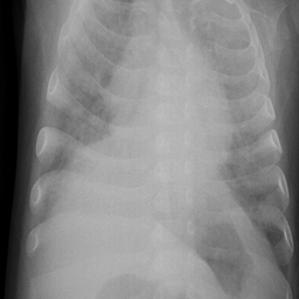

In [138]:
test_image

In [213]:
from transformers import pipeline

classifier = pipeline("image-classification", model="covid_radiology_classification")
classifier(test_image)

[{'label': 'COVID', 'score': 0.7238432765007019},
 {'label': 'Lung_Opacity', 'score': 0.2456500083208084},
 {'label': 'Normal', 'score': 0.01795921102166176},
 {'label': 'Viral Pneumonia', 'score': 0.01254752092063427}]

In [139]:
from transformers import AutoImageProcessor
import torch

image_processor = AutoImageProcessor.from_pretrained("covid_radiology_classification")
inputs = image_processor(test_image, return_tensors="pt")

In [152]:
with torch.no_grad():
    logits = model(**inputs).logits
    
assert int(logits.argmax()) == int(dataset['train'][index]['label'])

In [149]:
int(logits.argmax().numpy()) 

3

# Test accuracy

In [154]:
test_set = dataset['test']
correct = 0
total = len(test_set)

for i in range(len(test_set)):
    image = test_set[i]['image']
    label = test_set[i]['label']
    inputs = image_processor(image, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits 
    if int(logits.argmax()) == label:
        correct += 1
print(correct/total, ' Accuracy')

0.9273879142300195  Accuracy


In [143]:
len(dataset['test'])

2052

In [185]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("covid_radiology_classification")
with torch.no_grad():
    logits = model(inputs['pixel_values']).logits
logits

tensor([[-0.9365, -1.3929, -0.8797,  2.8826]])

# Shap implementation

In [155]:
import numpy as np
import shap

In [156]:
from datasets import load_dataset

dataset = load_dataset('imagefolder', data_dir='jpeg')

In [222]:
index = 10010
test_image = dataset['train'][index]['image']
dataset['train'][index]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=299x299>,
 'label': 2}

In [211]:
from transformers import AutoImageProcessor
import torch

image_processor = AutoImageProcessor.from_pretrained("covid_radiology_classification")
inputs = image_processor(test_image, return_tensors="pt")
x_test = inputs['pixel_values'].numpy()
x_trans = x_test.transpose(0,2,3,1)
x_trans.shape

(1, 224, 224, 3)

In [212]:

class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

In [213]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("covid_radiology_classification")

In [163]:
# python function to get model output; replace this function with your own model function.
import tensorflow as tf
def f(inputs):
    # print(inputs.shape)
    inputs = inputs.transpose(0,3,1,2)
    inputs = torch.Tensor(inputs)
    with torch.no_grad():
        logits = model(inputs).logits
    # print(logits)
    return logits.numpy()

In [214]:
f(x_trans)

array([[ 3.2319183, -0.9363855, -1.0156516, -1.1067157]], dtype=float32)

In [194]:



# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("blur(128,128)", x_trans[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values12500 = explainer(x_trans, max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])

PartitionExplainer explainer: 2it [00:30, 30.61s/it]               


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


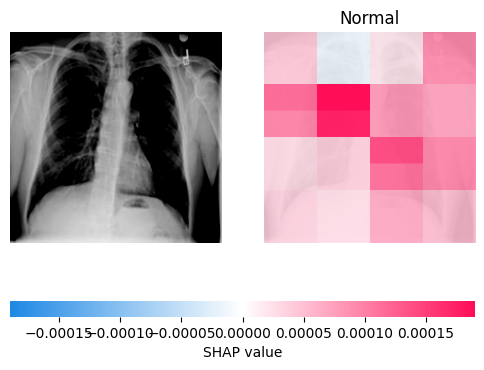

In [190]:
# output with shap values
shap.image_plot(shap_values12345)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


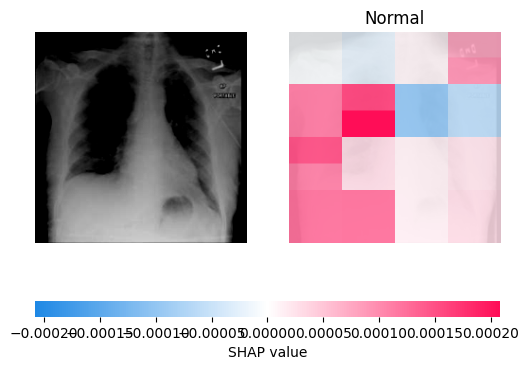

In [195]:
# output with shap values
shap.image_plot(shap_values12500)

In [196]:
combined = shap_values12345 + shap_values12500

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


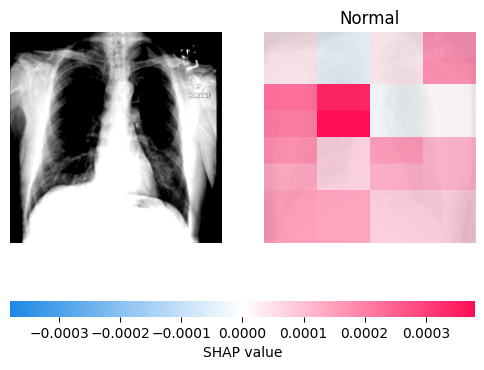

In [197]:
shap.image_plot(combined)

## Combine Shapley Values

In [ ]:
import numpy as np
import shap

In [ ]:
from datasets import load_dataset

dataset = load_dataset('imagefolder', data_dir='jpeg')

In [ ]:

class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

In [ ]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("covid_radiology_classification")

In [ ]:
# python function to get model output; replace this function with your own model function.
import tensorflow as tf
def f(inputs):
    # print(inputs.shape)
    inputs = inputs.transpose(0,3,1,2)
    inputs = torch.Tensor(inputs)
    with torch.no_grad():
        logits = model(inputs).logits
    # print(logits)
    return logits.numpy()

In [ ]:
from transformers import AutoImageProcessor
import torch

image_processor = AutoImageProcessor.from_pretrained("covid_radiology_classification")


(1, 224, 224, 3)

In [225]:
test_set = dataset['train']
start_index = 10000
iterations = 10
predictions = []
all_values = None

for i in range(start_index, start_index + iterations):
    image = test_set[i]['image']
    inputs = image_processor(image, return_tensors="pt")
    x_test = inputs['pixel_values'].numpy()
    x_trans = x_test.transpose(0,2,3,1)

    # define a masker that is used to mask out partitions of the input image.
    masker = shap.maskers.Image("blur(128,128)", x_trans[0].shape)

    # create an explainer with model and image masker
    explainer = shap.Explainer(f, masker, output_names=class_names)

    # here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
    shap_values = explainer(x_trans, max_evals=2000, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])
    predictions.append(shap_values.output_names)
    if all_values == None:
        all_values = shap_values
    else:
        all_values += shap_values


PartitionExplainer explainer: 2it [10:05, 605.85s/it]              
PartitionExplainer explainer: 2it [09:49, 589.45s/it]              
PartitionExplainer explainer: 2it [09:56, 596.04s/it]              
PartitionExplainer explainer: 2it [09:38, 578.12s/it]              
PartitionExplainer explainer: 2it [09:38, 578.22s/it]              
PartitionExplainer explainer: 2it [09:39, 579.76s/it]              
PartitionExplainer explainer: 2it [09:39, 579.31s/it]              
PartitionExplainer explainer: 2it [09:36, 576.60s/it]              
PartitionExplainer explainer: 2it [09:38, 578.73s/it]              
PartitionExplainer explainer: 2it [09:39, 579.11s/it]              


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


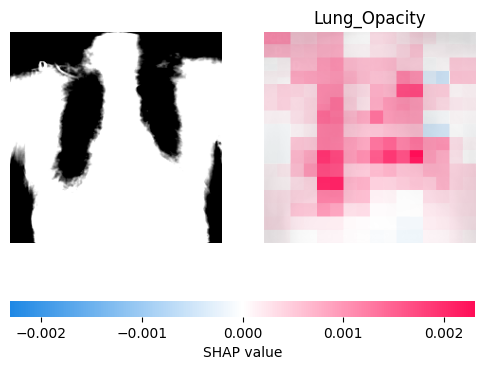

In [203]:
#Covid part 1
shap.image_plot(all_values)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


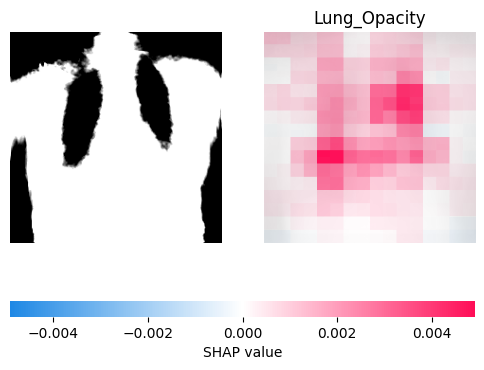

In [219]:
#Covid part 2
shap.image_plot(all_values)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


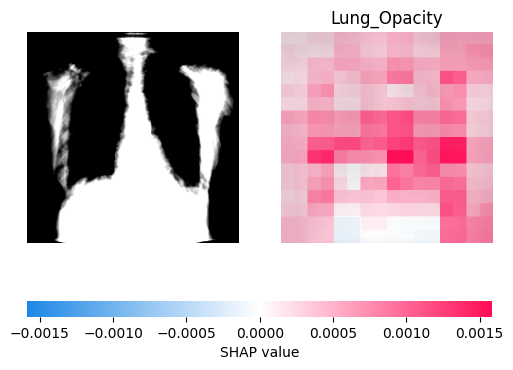

In [226]:
#Normal part 1
shap.image_plot(all_values)

In [227]:
predictions

[['Lung_Opacity'],
 ['Normal'],
 ['Normal'],
 ['Normal'],
 ['Normal'],
 ['Normal'],
 ['Normal'],
 ['Normal'],
 ['Normal'],
 ['Normal']]

# Change png to jpg

In [116]:
from PIL import Image 
import os 

path = 'COVID-19_Radiography_Dataset/train/Viral Pneumonia'

out_path = 'jpeg/train/Viral_Pneumonia'

files = os.listdir(path) # list of files in directory

for file in files:  

    if file.endswith('.png'): # check if file is png

        im = Image.open(f'{path}/'+ file).convert("RGB") # open file as an image object

        im.save(f'{out_path}/' + file[:-4] + '.jpg') # save image as jpg with options